In [1]:
# import Math library
import math
from IPython import display

# Importing matplotlib for better graphical visualization
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import seaborn as sns

# import numpy for numerical computing
import numpy as np
# import pandas for dataframe
import pandas as pd

import missingno as msno
from sklearn import metrics
from sklearn.preprocessing import scale, StandardScaler, normalize
from sklearn import preprocessing
from sklearn import decomposition

# import PCA 
from sklearn.decomposition import PCA
# import kmeans for clustering 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import pickle
from collections import Counter

# import python plot
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.1f}'.format

%matplotlib inline
warnings.filterwarnings("ignore")

**Task 1 - data analysis**

**Data import and cleaning**

In [2]:
# loading online retail dataset dataset
data = pd.read_excel("/Users/ruchitha/Desktop/DataMining_Projects/Online-retail-Analysis/clean_data.xlsx")

In [3]:
# remoing all not applicable columns
data = data.dropna() 

In [4]:
total_cost = data['Quantity'] * data['UnitPrice']

In [5]:
# Classifying the customers based on the amount spent
spend_label = []
for i in range(0,len(data),1):
    if data['total_cost'].iloc[i] < 5000:
        spend_label.append(1)
    elif data['total_cost'].iloc[i] >50000:
        spend_label.append(3)
    else:
        spend_label.append(2)

In [6]:
# adding an additonal spent_label feature
data['spend_label'] = spend_label

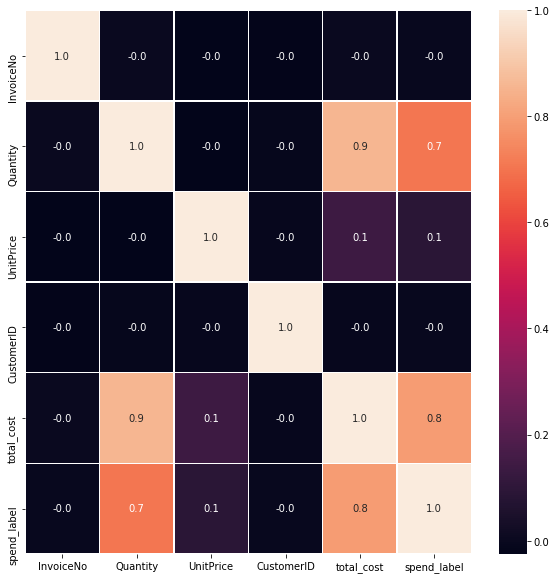

In [7]:
# heat map to look for correlation
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax);

The above table shows the correlation between the features under consideration

In [8]:
len(data.StockCode.unique()), len(data.Description.unique())

(3573, 3759)

In [9]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_cost,spend_label
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5,17850,United Kingdom,15.3,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.4,17850,United Kingdom,20.3,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.8,17850,United Kingdom,22.0,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.4,17850,United Kingdom,20.3,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.4,17850,United Kingdom,20.3,1


**Clustering : Group by customerID**

In [10]:
# Grouping customers by their ID
data_grouped = data.groupby('CustomerID')
data_cluster=pd.DataFrame(columns=['Quantity','UnitPrice', 'total_spend', 'CustomerID'])
count=0

In [11]:
# creating a dataset with just features which have high correlation values 
# as they can be used to make better predictions
for k,v in (data_grouped):
    data_cluster.loc[count] = [(v['Quantity'].sum()), v['UnitPrice'].sum(), v['total_cost'].sum(), k]
    count+=1

# Applying K-Means Clustering Algorithm to quantity, and total spend
X = data_cluster.iloc[:, [0, 2]].values

In [12]:
data_cluster.head()

,Quantity,UnitPrice,total_spend,CustomerID
0,74215.0,1.0,77183.6,12346.0
1,1590.0,346.9,2790.9,12347.0
2,2332.0,18.7,1437.2,12348.0
3,196.0,25.3,294.4,12350.0
4,401.0,267.3,1154.0,12352.0


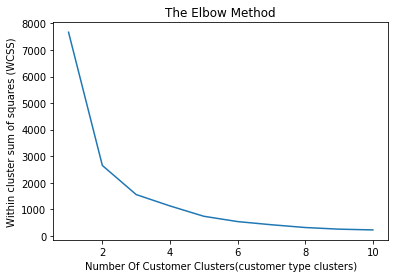

In [13]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X= sc_X.fit_transform(X)
#Using the Elbow method to find the optimum number of clusters
from sklearn.cluster import KMeans
wcss = [] #Within cluster sum of squares (inertia)

# n_clusters is no.of clusters given by this method,
# k-means++ is an random initialization methods for centriods to avoid random initialisation trap,
# max_iter is max no of iterations defined when k-means is running
# n_init is no of times k-means will run with different initial centroids

for i in range(1,11): #From 2-10 doing multiple random initializations can make a huge difference to find a better local optima
    kmeans = KMeans(n_clusters = i, init ='k-means++',max_iter=300,n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11) , wcss)
plt.title('The Elbow Method')
plt.xlabel('Number Of Customer Clusters(customer type clusters)')
plt.ylabel('Within cluster sum of squares (WCSS)')
plt.show()

Cluster that has a small sum of squares is more compact than a cluster that has a large sum of squares. We acn notice that the value is smallest for n =8 or 10.

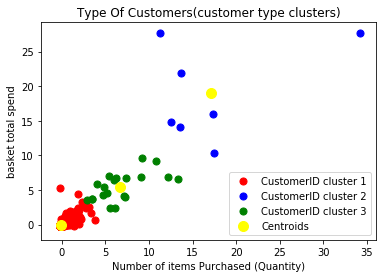

In [14]:
# Fitting K-Means to the dataset. Considering number of clusters to be 3
kmeans = KMeans(n_clusters = 3, init = 'k-means++')
y_kmeans = kmeans.fit_predict(X)

# Visualising the clusters
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 50, c = 'red', label = 'CustomerID cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 50, c = 'blue', label = 'CustomerID cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 50, c = 'green', label = 'CustomerID cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')
plt.title('Type Of Customers(customer type clusters)')
plt.xlabel('Number of items Purchased (Quantity)')
plt.ylabel('basket total spend')
plt.legend()
plt.show()


For n=3, we can see from the scatter plot that there is a boundary sperating clusters mostly

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



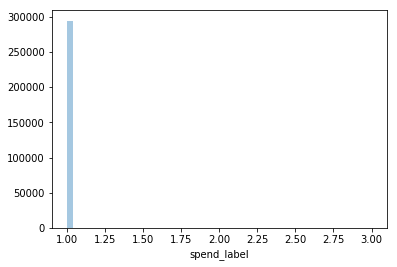

In [15]:
sns.distplot(data['spend_label'],kde = False)
plt.show()

From the above data we can notice that the data is quite imbalanced. so we make use of the transactions which involve lower values of the ttal amount spent by the customer to get rid of all outliers.

In [16]:
data2 = data[(data['total_cost'] >0) & (data['total_cost'] < 100)]

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



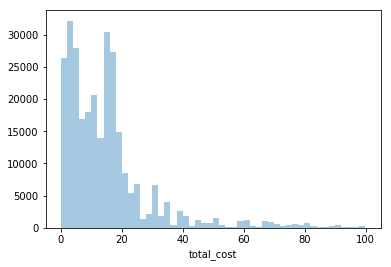

In [17]:
sns.distplot(data2['total_cost'],kde = False)
plt.show()

Now we change the range that we are using for binning, to have the data more balanced.

In [18]:
spend_label = []
for i in range(0,len(data2),1):
    if data2['total_cost'].iloc[i] < 10:
        spend_label.append(0)
    elif data2['total_cost'].iloc[i] >40:
        spend_label.append(2)
    else:
        spend_label.append(1)

In [19]:
data2['spend_label'] = spend_label

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [20]:
data2.shape # there is still a reasonably large sized data set to work with

(285380, 10)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



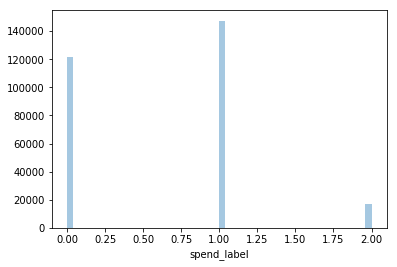

In [21]:
sns.distplot(data2['spend_label'],kde = False)
plt.show()

The data is still unbalanced for high range values but better than the one we had earlier

**Create dummy variables from the string columns (descriptions and country)**

In [22]:
#  Creating dummies for description
cols_to_transform = ['Description']
type_hash = pd.get_dummies(data=data2['Description'])
type_hash2 = pd.get_dummies(data=data2['Country'])

In [23]:
learning_data = pd.concat([data2, type_hash, type_hash2], axis=1)
learning_data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'total_cost', 'spend_label',
       ...
       'RSA', 'Saudi Arabia', 'Singapore', 'Spain', 'Sweden', 'Switzerland',
       'USA', 'United Arab Emirates', 'United Kingdom', 'Unspecified'],
      dtype='object', length=3792)

In [24]:
# drop the columns that are not required. Some are replaced by derived features 
droplist = ['Quantity','StockCode','InvoiceDate','InvoiceNo','UnitPrice','Description','Country','CustomerID']
learning_data = learning_data.drop(droplist, axis=1)

In [25]:
learning_data = learning_data.reset_index(drop=True)

In [26]:
# selecting the features for model training
xdata = learning_data.copy()
# deleting the target column from dataset
del xdata['spend_label']
# Target column for training the model
ydata = learning_data['spend_label']

In [27]:
# normalizing the data before model training for better prdictions
normalized_xdata = preprocessing.normalize(xdata)

In [28]:
# encoding the description and creating dummies for them
cols_to_transform = ['Description']
type_hash = pd.get_dummies(data=data2['Description'])

In [29]:
learning_data2 = pd.concat([data2, type_hash], axis=1)

In [30]:
learning_data2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_cost,spend_label,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,TRELLIS COAT RACK,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 PINK ROSE PEG PLACE SETTINGS,12 RED ROSE PEG PLACE SETTINGS,15 PINK FLUFFY CHICKS IN BOX,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PC CUTLERY SET PANTRY DESIGN,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,2 DAISIES HAIR COMB,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,2 PICTURE BOOK EGGS EASTER DUCKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,...,WRAP RED VINTAGE DOILY,WRAP SUKI AND FRIENDS,WRAP SUMMER ROSE DESIGN,WRAP VINTAGE LEAF DESIGN,WRAP VINTAGE PETALS DESIGN,WRAP WEDDING DAY,"WRAP, BILLBOARD FONTS DESIGN","WRAP, CAROUSEL",YELLOW BREAKFAST CUP AND SAUCER,YELLOW COAT RACK PARIS FASHION,YELLOW DRAGONFLY HELICOPTER,YELLOW EASTER EGG HUNT START POST,YELLOW FELT HANGING HEART W FLOWER,YELLOW FLOWERS FELT HANDBAG KIT,YELLOW GIANT GARDEN THERMOMETER,YELLOW METAL CHICKEN HEART,YELLOW PINK FLOWER DESIGN BIG BOWL,YELLOW POT PLANT CANDLE,YELLOW SHARK HELICOPTER,YELLOW/BLUE RETRO RADIO,YELLOW/ORANGE FLOWER DESIGN PLATE,YELLOW/PINK FLOWER DESIGN BIG MUG,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,YULETIDE IMAGES S/6 PAPER BOXES,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FINISH 15CM PLANTER POTS,ZINC FOLKART SLEIGH BELLS,ZINC HEART FLOWER T-LIGHT HOLDER,ZINC HEART LATTICE 2 WALL PLANTER,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC HEARTS PLANT POT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC PLANT POT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5,17850,United Kingdom,15.3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.4,17850,United Kingdom,20.3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.8,17850,United Kingdom,22.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.4,17850,United Kingdom,20.3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.4,17850,United Kingdom,20.3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [31]:
# drop the columns that have been now been replaced  by derived features 
droplist = ['Quantity','StockCode','InvoiceDate','InvoiceNo','UnitPrice','Description','spend_label','CustomerID']
learning_data2 = learning_data2.drop(droplist, axis=1)

In [32]:
learning_data2 = learning_data2.reset_index(drop=True)

In [33]:
# selecting the features for model training
xdata2 = learning_data2.copy()
# deleting the target colum from features set
del xdata2['Country']
# taget for training model
ydata2 = learning_data2['Country']

In [34]:
# convert ydata2 to integer
ydata2 = ydata2.astype('category')

In [35]:
normalized_xdata2 = preprocessing.normalize(xdata2)

**Machine learning - predicting customer spend**

In [36]:
# Libraries of model to make presdictions and to validate the models working
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report,accuracy_score, f1_score
from sklearn.model_selection import  cross_val_score
from sklearn.externals import joblib #for saving the trained model

In [37]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(normalized_xdata,ydata,test_size = 0.3, random_state = 8418) #70/30 training/test split - standard

In [38]:
import itertools

# confusion matrix plotting function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**Naive Bayes**

In [39]:
from sklearn.naive_bayes import GaussianNB #choose model class - done
nb_model = GaussianNB() #instantiate the model - done (GaussianNB has no hyperparameters)
nb_model.fit(xtrain, ytrain) #fit the model to the data

GaussianNB(priors=None)

In [40]:
# Use the trained model to predict on the test data
predictions = list(nb_model.predict(xtest))
accuracy = accuracy_score(ytest, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Recall:', recall_score(ytest, predictions,average="micro")*100,"%")
print('Precision:', precision_score(ytest, predictions,average="micro")*100,"%")

Accuracy: 62.11%
Recall: 62.10549676454785 %
Precision: 62.10549676454785 %


We can notice from the above values that there is scope for further improvement as model does not work as intended to a good extent.

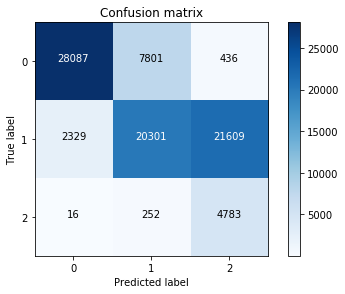

In [41]:
dat = confusion_matrix(ytest, predictions)

plot_confusion_matrix(
    dat, classes=[0,1,2], title='Confusion matrix')
plt.show()

**GradientBoost: LightGBM**

In [42]:
import lightgbm as lgb

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.



In [43]:
train_data=lgb.Dataset(xtrain,label=ytrain)

In [44]:
params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':3,
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'max_depth': 7,
    'num_leaves': 17,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.6,
    'bagging_freq': 17}

lgb_cv = lgb.cv(params, train_data, num_boost_round=10000, nfold=5, shuffle=True, stratified=True, verbose_eval=20, early_stopping_rounds=100)

nround = lgb_cv['multi_logloss-mean'].index(np.min(lgb_cv['multi_logloss-mean']))

[20]	cv_agg's multi_logloss: 0.453819 + 0.000163947
[40]	cv_agg's multi_logloss: 0.220787 + 0.000151727
[60]	cv_agg's multi_logloss: 0.118742 + 0.000151271
[80]	cv_agg's multi_logloss: 0.0645246 + 0.000144939
[100]	cv_agg's multi_logloss: 0.0332158 + 0.000140489
[120]	cv_agg's multi_logloss: 0.0174578 + 0.000139488
[140]	cv_agg's multi_logloss: 0.0101588 + 0.000125824
[160]	cv_agg's multi_logloss: 0.00577209 + 0.000130817
[180]	cv_agg's multi_logloss: 0.00339586 + 0.00012743
[200]	cv_agg's multi_logloss: 0.00205307 + 0.00012242
[220]	cv_agg's multi_logloss: 0.00136451 + 0.000121013
[240]	cv_agg's multi_logloss: 0.000937382 + 0.000121517
[260]	cv_agg's multi_logloss: 0.000657034 + 0.000119811
[280]	cv_agg's multi_logloss: 0.000525618 + 0.000122068
[300]	cv_agg's multi_logloss: 0.000456182 + 0.00012462
[320]	cv_agg's multi_logloss: 0.000415806 + 0.000122122
[340]	cv_agg's multi_logloss: 0.00037901 + 0.00013037
[360]	cv_agg's multi_logloss: 0.000359718 + 0.000124999
[380]	cv_agg's multi_l

In [45]:
model = lgb.train(params, train_data, num_boost_round=nround)

In [46]:
#predicting on test set
ypred=model.predict(xtest)

In [47]:
# convert the array of probabilities for each class output by LightGBM into a single list 
# containing the class with the highest probability.

predictions = []

for x in ypred:
    predictions.append(np.argmax(x))

In [48]:
accuracy = accuracy_score(ytest, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Recall:', recall_score(ytest, predictions,average="micro")*100,"%")
print('Precision:', precision_score(ytest, predictions,average="micro")*100,"%")

Accuracy: 99.98%
Recall: 99.98481556754736 %
Precision: 99.98481556754736 %


We can see that this model prediction capability is good

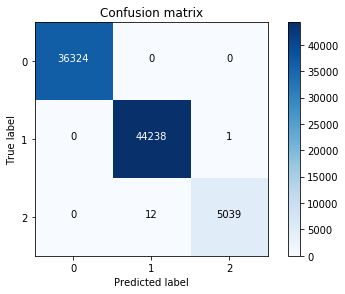

In [49]:
dat = confusion_matrix(ytest, predictions)

plot_confusion_matrix(
    dat, classes=[0,1,2], title='Confusion matrix')
plt.show()

**Machine learning - predicting country of origin**

In [50]:
xtrain, xtest, ytrain, ytest = train_test_split(normalized_xdata2,ydata2,test_size = 0.3, random_state = 8418) #70/30 training/test split - standard

In [51]:
nb_model2 = GaussianNB() #instantiate the model - done (GaussianNB has no hyperparameters)
nb_model2.fit(xtrain, ytrain) #fit the model to the data

GaussianNB(priors=None)

In [52]:
# Use the trained model to predict on the test data
predictions = list(nb_model2.predict(xtest))

In [53]:
accuracy = accuracy_score(ytest, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

print('Recall:', recall_score(ytest, predictions,average="micro")*100)
print('Precision:', precision_score(ytest, predictions,average="micro")*100)

Accuracy: 7.66%
Recall: 7.663466255518957
Precision: 7.663466255518957


Model does not work well

**GradientBoostin: LightGBM**

In [54]:
# convert string label to float & make new sets for LightGBM
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
ydata_float = lb.fit_transform(ydata2)

xtrain, xtest, ytrain, ytest = train_test_split(normalized_xdata2,ydata_float,test_size = 0.3, random_state = 8418) #70/30 training/test split - standard

In [55]:
train_data=lgb.Dataset(xtrain,label=ytrain)

In [56]:
params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':37,
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'max_depth': 7,
    'num_leaves': 17,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.6,
    'bagging_freq': 17}

lgb_cv = lgb.cv(params, train_data, num_boost_round=10000, nfold=5, shuffle=True, stratified=True, verbose_eval=20, early_stopping_rounds=100)

nround = lgb_cv['multi_logloss-mean'].index(np.min(lgb_cv['multi_logloss-mean']))

[20]	cv_agg's multi_logloss: 1.13298 + 0.0012676
[40]	cv_agg's multi_logloss: 0.777325 + 0.00124495
[60]	cv_agg's multi_logloss: 0.657756 + 0.00140435
[80]	cv_agg's multi_logloss: 0.612428 + 0.00166689
[100]	cv_agg's multi_logloss: 0.593498 + 0.00189162
[120]	cv_agg's multi_logloss: 0.583033 + 0.00198964
[140]	cv_agg's multi_logloss: 0.577493 + 0.00200542
[160]	cv_agg's multi_logloss: 0.574449 + 0.00205914
[180]	cv_agg's multi_logloss: 0.572362 + 0.00214975
[200]	cv_agg's multi_logloss: 0.570935 + 0.00220593
[220]	cv_agg's multi_logloss: 0.570193 + 0.00222563
[240]	cv_agg's multi_logloss: 0.569572 + 0.00230161
[260]	cv_agg's multi_logloss: 0.571507 + 0.00441704
[280]	cv_agg's multi_logloss: 0.571669 + 0.00501266
[300]	cv_agg's multi_logloss: 0.569287 + 0.00229977
[320]	cv_agg's multi_logloss: 0.569241 + 0.00229556
[340]	cv_agg's multi_logloss: 0.569307 + 0.00226408
[360]	cv_agg's multi_logloss: 0.570741 + 0.00424561
[380]	cv_agg's multi_logloss: 0.569914 + 0.00275463
[400]	cv_agg's mul

In [58]:
lgbm_model2 = lgb.train(params, train_data, num_boost_round=nround)

In [59]:
#predicting on test set
ypred=lgbm_model2.predict(xtest)

In [60]:
predictions = []

for x in ypred:
    predictions.append(np.argmax(x))

In [61]:
accuracy = accuracy_score(ytest, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Recall:', recall_score(ytest, predictions,average="micro")*100,"%")
print('Precision:', precision_score(ytest, predictions,average="micro")*100,"%")

Accuracy: 89.20%
Recall: 89.1980283598477 %
Precision: 89.1980283598477 %


This model gives better result.